In [25]:
import pymongo

client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["ProgettoBD2"]

food = db["food"]
global_dataset = db["global_dataset"]
global_inflation = db["global_inflation"]
us_cpi = db["consumer_price_index"]

In [26]:
import utils

query = {"High": {"$gt": 20}}
utils.query_print_all(food, query)

{'_id': ObjectId('6655ac354d00c539704c52cc'), 'Open': 21, 'High': 21.58, 'Low': 20.42, 'Close': 21.13, 'Inflation': 153.8, 'country': 'Lebanon', 'ISO3': 'LBN', 'date': datetime.datetime(2022, 10, 1, 0, 0)}
{'_id': ObjectId('6655ac354d00c539704c52cd'), 'Open': 22.85, 'High': 23.35, 'Low': 21.47, 'Close': 21.47, 'Inflation': 126.15, 'country': 'Lebanon', 'ISO3': 'LBN', 'date': datetime.datetime(2022, 11, 1, 0, 0)}
{'_id': ObjectId('6655ac354d00c539704c52ce'), 'Open': 22.69, 'High': 23.41, 'Low': 21.98, 'Close': 23, 'Inflation': 108.36, 'country': 'Lebanon', 'ISO3': 'LBN', 'date': datetime.datetime(2022, 12, 1, 0, 0)}
{'_id': ObjectId('6655ac354d00c539704c52cf'), 'Open': 24.96, 'High': 25.57, 'Low': 24.35, 'Close': 25.33, 'Inflation': 107.23, 'country': 'Lebanon', 'ISO3': 'LBN', 'date': datetime.datetime(2023, 1, 1, 0, 0)}
{'_id': ObjectId('6655ac354d00c539704c52d0'), 'Open': 27.4, 'High': 27.95, 'Low': 26.19, 'Close': 26.19, 'Inflation': 131.5, 'country': 'Lebanon', 'ISO3': 'LBN', 'date'

## Collection: Food
Sono solo kebabbari e talebani

In [27]:
countries = food.distinct("country")
countries

['Afghanistan',
 'Burkina Faso',
 'Burundi',
 'Cameroon',
 'Central African Republic',
 'Chad',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 'Gambia, The',
 'Guinea-Bissau',
 'Haiti',
 'Iraq',
 'Lao PDR',
 'Lebanon',
 'Liberia',
 'Mali',
 'Mozambique',
 'Myanmar',
 'Niger',
 'Nigeria',
 'Somalia',
 'South Sudan',
 'Sudan',
 'Syrian Arab Republic',
 'Yemen, Rep.']

In [28]:
countries = global_dataset.distinct("Country")
countries

['Afghanistan',
 'Albania',
 'Algeria',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas, The',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'British Virgin Islands',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cayman Islands',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 'Costa Rica',
 'Croatia',
 'Curacao',
 'Cyprus',
 'Czech Republic',
 "Côte d'Ivoire",
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt, Arab Rep.',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia, The',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Grenada',
 'Guatemala',
 'Gui

## Collection: Global Dataset
L'inflazione è suddivisa in categorie

In [29]:
query = {"Country": "Italy"}
utils.query_print_parameter(global_dataset, query, "Series Name")

Headline Consumer Price Inflation
Energy Consumer Price Inflation
Food Consumer Price Inflation
Official Core Consumer Price Inflation
Producer Price Inflation


In [30]:
countries = global_inflation.distinct("country_name")
countries

['Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas, The',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 "China, People's Republic of",
 'Colombia',
 'Comoros',
 'Congo, Dem. Rep. of the',
 'Congo, Republic of ',
 'Costa Rica',
 'Croatia',
 'Cyprus',
 'Czech Republic',
 "Côte d'Ivoire",
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia, The',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Grenada',
 'Guatemala',
 'Guinea',
 

## Collection: Global Inflation
Vedi sopra

In [31]:
query = {"country_name": "Italy"}
utils.query_print_all(global_inflation, query)

{'_id': ObjectId('6655abcb4d00c539704c43b5'), '1980': 21.8, '1981': 19.5, '1982': 16.5, '1983': 14.7, '1984': 10.7, '1985': 9, '1986': 5.8, '1987': 4.7, '1988': 5.1, '1989': 6.2, '1990': 6.4, '1991': 6.2, '1992': 5, '1993': 4.5, '1994': 4.2, '1995': 5.4, '1996': 4, '1997': 1.8, '1998': 2, '1999': 1.7, '2000': 2.6, '2001': 2.3, '2002': 2.6, '2003': 2.8, '2004': 2.3, '2005': 2.2, '2006': 2.2, '2007': 2, '2008': 3.5, '2009': 0.8, '2010': 1.6, '2011': 2.9, '2012': 3.3, '2013': 1.2, '2014': 0.2, '2015': 0.1, '2016': -0.1, '2017': 1.3, '2018': 1.2, '2019': 0.6, '2020': -0.1, '2021': 1.9, '2022': 8.7, '2023': 6, '2024': 2.6, 'country_name': 'Italy', 'indicator_name': 'Annual average inflation (consumer prices) rate'}


Estrazione Paese con maggiore inflazione in base all'anno

In [32]:
# Query per trovare il paese con la massima inflazione in un anno specifico
anno = 2024
max_inflation = utils.get_max_infl_year(global_inflation, anno)

country_max_infl = global_inflation.find_one({"_id": max_inflation.next()['_id']})
country_name = country_max_infl['country_name']
print(f"Il paese con la maggiore inflazione nel {anno} è: {country_name} con un valore di {country_max_infl[str(anno)]}%")

Il paese con la maggiore inflazione nel 2024 è: Zimbabwe con un valore di 222.4%


In [33]:
del country_max_infl['_id']
del country_max_infl['country_name']
del country_max_infl['indicator_name']

Plot dell'inflazione annuale per il paese con la maggiore inflazione precedentemente calcolata

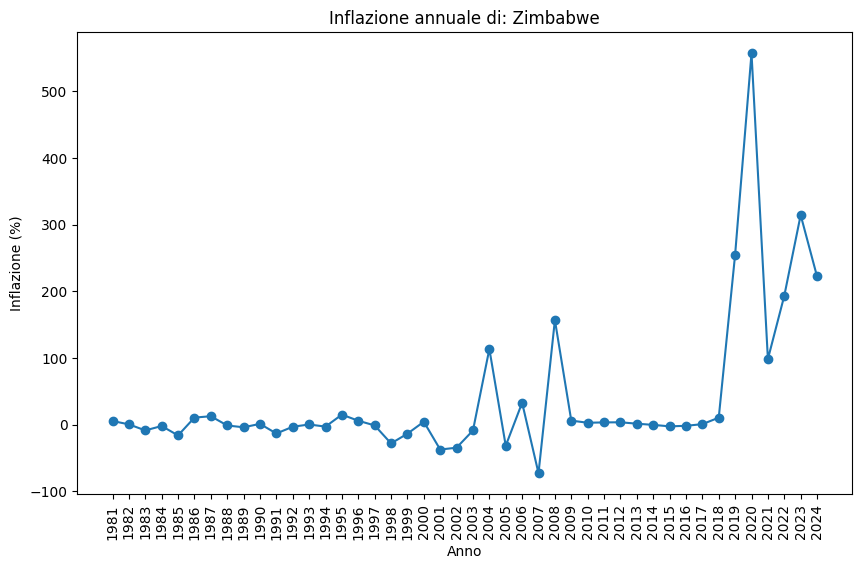

In [34]:
import matplotlib.pyplot as plt

anni = list(country_max_infl.keys())
inflazione = list(country_max_infl.values())
plt.figure(figsize=(10, 6))
plt.plot(anni, inflazione, marker='o', label='Inflazione annuale')
plt.xlabel('Anno')
plt.ylabel('Inflazione (%)')
plt.title(f'Inflazione annuale di: {country_name}')
plt.xticks(rotation=90)
plt.show()

Inflazione media per paese

In [35]:
country_name = "Italy"
avg_ita_infl = utils.get_avg_infl_years(global_inflation, country_name)
print(f"L'inflazione media in {country_name} dal 1980 al 2024 è {avg_ita_infl.next()['avgInflation']:.2f}%")

L'inflazione media in Italy dal 1980 al 2024 è 4.66%


In [36]:
# Codice USA | Map e reduce?

## Collection: Consumer Price Index